# Multi-Fidelity Bayesian Optimization: Investigating a Minimal Toy Problem

(Inspired by "A Tutorial on Vanilla Bayesian Optimization" by Darian Nwankwo)

In [2]:
using Plots; plot() # warm start plotting engine
using LinearAlgebra
using Distributions
using Optim
using ForwardDiff

In [3]:
include("../src/mfbo.jl")

optimize_surrogate (generic function with 1 method)

## 1. Gather Initial Samples
Our first step is to run some initial experiments and collect our data locations into some matrix $X$ and observations into some vector $y$. Our "experiments" will be random evaluations of some test function; in practice, our function is black-boxed. Put these obervations into an nxd matrix X.

Test Function: GramacyLee


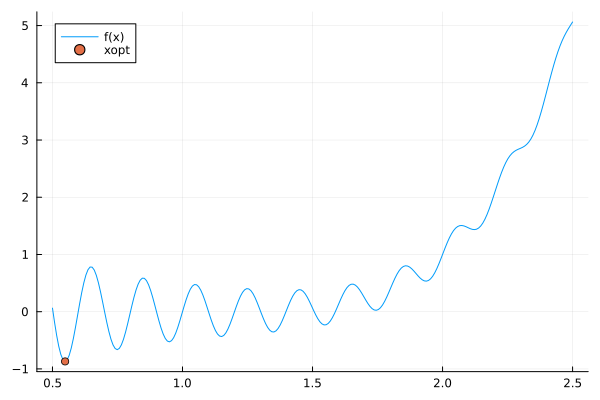

In [4]:
testfn, testfn_name, X, y =  get_toy_problem(N=4, fn_name = "GramacyLee")
println("Test Function: $(testfn_name)")
tplot(testfn)

## 2. Initialize surrogate model

Gather information regarding predictive mean and variance for our function. I will use kernels defined in kernels.jl.

In [5]:
#this will be changed so don't always
ψ = SquaredExponential(1.)

Node{Kernel}(Kernel([1.0], var"#squared_exponential#173"{Float64}(1.0), var"#squared_exponential_hypers#174"(), var"#101#107"{var"#squared_exponential#173"{Float64}}(var"#squared_exponential#173"{Float64}(1.0)), var"#103#109"{var"#squared_exponential#173"{Float64}}(var"#squared_exponential#173"{Float64}(1.0)), var"#105#111"{Vector{Float64}, var"#squared_exponential_hypers#174"}([1.0], var"#squared_exponential_hypers#174"()), SquaredExponentialConstructor, SquaredExponential, [1]), nothing, nothing)

In [6]:
sur = GP(ψ, X, y, noise = 1e-6)

GaussianProcess{Matrix{Float64}, Vector{Float64}, Float64}(Kernel([1.0], var"#squared_exponential#173"{Float64}(1.0), var"#squared_exponential_hypers#174"(), var"#101#107"{var"#squared_exponential#173"{Float64}}(var"#squared_exponential#173"{Float64}(1.0)), var"#103#109"{var"#squared_exponential#173"{Float64}}(var"#squared_exponential#173"{Float64}(1.0)), var"#105#111"{Vector{Float64}, var"#squared_exponential_hypers#174"}([1.0], var"#squared_exponential_hypers#174"()), SquaredExponentialConstructor, SquaredExponential, [1]), [0.5299074180124284 2.329214761955403 0.9757009933502323 1.009309295284078], [1.000001 0.19814554174691112 0.9054113067728425 0.8914436248498269; 0.19814554174691112 1.000001 0.40011640532337145 0.4185013260520704; 0.9054113067728425 0.40011640532337145 1.000001 0.9994354004668965; 0.8914436248498269 0.4185013260520704 0.9994354004668965 1.000001], [1.000000499999875 0.0 0.0 0.0; 0.19814544267421455 0.9801731395765951 0.0 0.0; 0.9054108540675286 0.2251779424780643

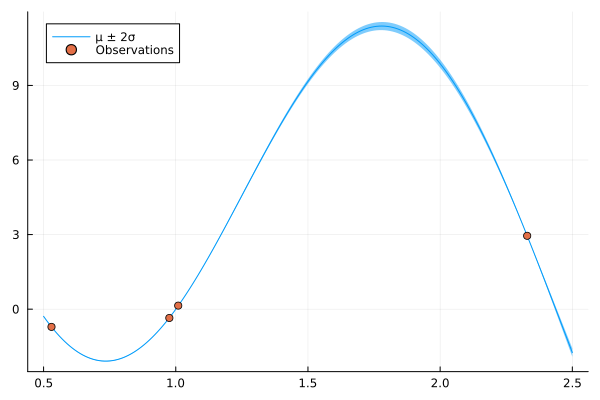

In [7]:
domain = first(testfn.bounds[:, 1]):0.01:first(testfn.bounds[:, 2])
plot1d(sur, interval = domain)

## 3. Construct Acquisition Function

Create some general acquisition functions for this step

In [8]:
af, af_name = get_random_acquisitionfn(sur)
plotaf1d(af, interval = domain)

LoadError: UndefKeywordError: keyword argument `lbs` not assigned

## 4. Optimize the acquisition function
Given our acquisition function, optimizing it directly. Thus, select the best location according to the chosen selection criteria.



In [9]:
# Consider taking all 4 acquisition functions, seeing their x values
# find the y values corresponding with these x values. Choose the AF
# which yields the highest y (as we are maximizing).
function optimize_acquisition_functions(sur::GaussianProcess, X::Vector{Float64}, y::Vector{Float64})
    xopt = 1.0
    lb, ub = minimum(X), maximum(X)
    best_val = -Inf
    best_fn = ""

    for (fn_name, fn) in get_acquisition_functions(sur)
        res = optimize(
            x -> -fn.f(x),
            lb,
            ub
        )
        val = -Optim.minimum(res)  # Minimize negative to maximize
        if val > best_val
            best_val = val
            xopt = Optim.minimizer(res)[1]
            best_fn = fn_name
        end
    end

    println("Optimal x: ", xopt)
    println("Optimal value: ", best_val)
    println("Best acquisition function: ", best_fn)
    return xopt
end

optimize_acquisition_functions (generic function with 1 method)

In [10]:
lbs_ = testfn.bounds[:, 1]
ubs_ = testfn.bounds[:, 2]
EIx=EI(sur, lbs=lbs_, ubs=ubs_)
Xopt=optimize_acquisition(EIx)

1-element Vector{Float64}:
 0.7351059882243005

## 5. Sample data at new recommendation

A toy example of what sampling at a new point looks like

In [11]:
X_1, y_1 = Xopt, testfn.f(Xopt)
sur = schur_update(sur, X_1, y_1)

GaussianProcess{Matrix{Float64}, Vector{Float64}, Float64}(Kernel([1.0], var"#squared_exponential#173"{Float64}(1.0), var"#squared_exponential_hypers#174"(), var"#101#107"{var"#squared_exponential#173"{Float64}}(var"#squared_exponential#173"{Float64}(1.0)), var"#103#109"{var"#squared_exponential#173"{Float64}}(var"#squared_exponential#173"{Float64}(1.0)), var"#105#111"{Vector{Float64}, var"#squared_exponential_hypers#174"}([1.0], var"#squared_exponential_hypers#174"()), SquaredExponentialConstructor, SquaredExponential, [1]), [0.5299074180124284 2.329214761955403 … 1.009309295284078 0.7351059882243005], [1.000001 0.19814554174691112 … 0.8914436248498269 0.9791668454520726; 0.19814554174691112 1.000001 … 0.4185013260520704 0.28066558951628723; … ; 0.8914436248498269 0.4185013260520704 … 1.000001 0.9631041448196191; 0.9791668454520726 0.28066558951628723 … 0.9631041448196191 1.000001], [1.000000499999875 0.0 … 0.0 0.0; 0.19814544267421455 0.9801731395765951 … 0.0 0.0; … ; 0.8914431791283

In [12]:
EIx=EI(sur, lbs=lbs_, ubs=ubs_)
Xopt=optimize_acquisition(EIx)

1-element Vector{Float64}:
 2.4999999999595275

## 6. Repeat until budget exhausted and provide final recommendation.

We repeat updating our surrogate and sampling at our new recommendation. Perform this process on all four acquisition functions to see how results vary.

In [13]:
BUDGET = 1000

1000

In [14]:
# View different results from different acquisition functions
is_EI = true
is_POI = false
is_UCB = false
is_LCB = false

false

In [15]:
if is_EI
    for i=1:BUDGET
        print('|')
        EIx=EI(sur, lbs=lbs_, ubs=ubs_)
        Xopt=optimize_acquisition(EIx)
        X_1, y_1 = Xopt, testfn.f(Xopt)
        sur = schur_update(sur, X_1, y_1)
    end

    Xopt
end

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

1-element Vector{Float64}:
 1.298644816079687

In [16]:
if is_POI
    POIx=POI(sur, lbs=lbs_, ubs=ubs_)
    Xopt=optimize_acquisition(POIx)

    # Arbitrary number of iterations of budget
    for i=1:BUDGET
        print('|')
        POIx=POI(sur_1, lbs=lbs_, ubs=ubs_)
        Xopt=optimize_acquisition(POIx)
        X_1, y_1 = Xopt, testfn.f(Xopt)
        sur = schur_update(sur, X_1, y_1)
    end

    Xopt
end

In [17]:
if is_LCB
    LCBx=LCB(sur, lbs=lbs_, ubs=ubs_)
    Xopt=optimize_acquisition(LCBx)

    for i=1:BUDGET
        print('|')
        LCBx=LCB(sur, lbs=lbs_, ubs=ubs_)
        Xopt=optimize_acquisition(LCBx)
        X_1, y_1 = Xopt, testfn.f(Xopt)
        sur = schur_update(sur, X_1, y_1)
    end

    Xopt
end

In [18]:
if is_UCB
    UCBx=UCB(sur, lbs=lbs_, ubs=ubs_)
    Xopt=optimize_acquisition(UCBx)

    for i=1:BUDGET
        print('|')
        UCBx=UCB(sur, lbs=lbs_, ubs=ubs_)
        Xopt=optimize_acquisition(UCBx)
        X_1, y_1 = Xopt, testfn.f(Xopt)
        sur = schur_update(sur, X_1, y_1)
    end

    Xopt
end

## 7. Make final recommendation

Once budget is exhausted, make final recommendation.

In [19]:
println("Final x recommendation (argmin): " * string(Xopt))
println("Final y recommendation (min): " * string(testfn.f(Xopt)))

Final x recommendation (argmin): [1.298644816079687]
Final y recommendation (min): 0.02434151833896394


Test Function: GramacyLee


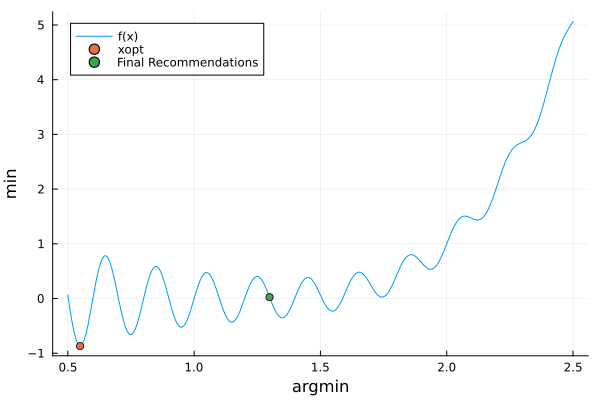

In [20]:
using Plots

# Obtain test function and its name, along with X, y data
testfn, testfn_name, X, y = get_toy_problem(N=4, fn_name="GramacyLee")

# Print test function name
println("Test Function: $testfn_name")

# Plot the test function
tplot(testfn)

# Plot the final recommendations
scatter!(repeat([Xopt], 1), repeat([testfn.f(Xopt)], 1), label="Final Recommendations", xlabel="argmin", ylabel="min", legend=:topleft)

# Show plot
plot!()
